In [14]:
%matplotlib inline
from math import log
from numpy import average, array, clip, dstack, histogram
from skimage.color import rgb2gray
from skimage.io import imread, imsave, imshow
from skimage.util import img_as_ubyte, img_as_float


def downgrade(img, levels_n: int = 256):
    '''Уменьшение кол-ва уровней яркости изображения'''
    downgraded_img = img // (256 // levels_n)
    return downgraded_img


def restore(img, levels_n: int = 256):
    '''восстановление изображения для просмотра'''
    restored_img = img * (256 // levels_n)
    return restored_img


img_name = ('C:\cs173\lab1\eye.jpg')
img = imread(img_name)
img_gray = rgb2gray(img)
img_one_channel = img_as_ubyte(img_gray)
levels_n = 16
downgraded_img = downgrade(img_one_channel, levels_n)
restored_img = restore(downgraded_img, levels_n)
imsave(f'restored_img_{levels_n}_levels.png', restored_img)

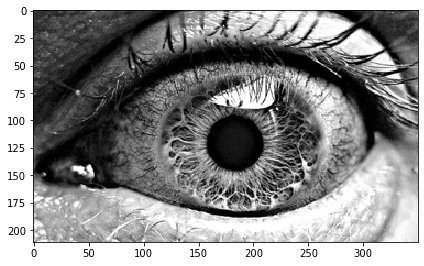

In [15]:
imshow(img_name)

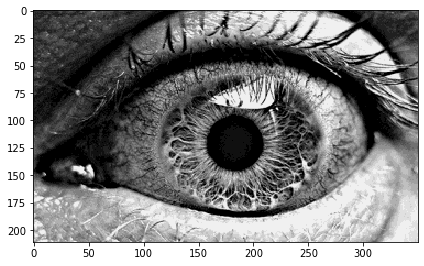

In [16]:
#  На 16 уровнях яркости изображение выглядит ещё приемлемо

output_img = imread('C:\cs173\lab1\\restored_img_16_levels.png')
imshow(output_img)

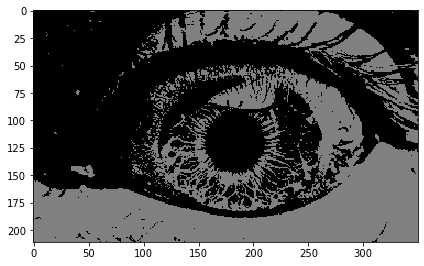

In [17]:
#  Так выглядит на 2 уровнях:

output_img = imread('C:\cs173\lab1\\restored_img_2_levels.png')
imshow(output_img)

In [18]:
def decimate(channel):
    ch = []
    for x in range(channel.shape[0]):
        if x % 2 != 0:
            ch.append([])
        for y in range(channel.shape[1]):
            if x % 2 != 0 and y % 2 != 0:
                avg = average(channel[x-1: x, y-1: y])
                ch[x // 2].append(avg)
    ch = array(ch)
    return ch


def rgb_to_yuv(img) -> tuple:
    r = img[:, :, 0]
    g = img[:, :, 1]
    b = img[:, :, 2]
    '''
    y_channel = r.copy()
    v_channel = r.copy()
    u_channel = r.copy()
    for x in range(y_channel.shape[0]):
        for y in range(y_channel.shape[1]):
            y_channel[x, y] = int(round(0.299 * r[x, y] + 0.587 * g[x, y] + 0.114 * b[x, y]))
            u_channel[x, y] = int(round(-0.147 * r[x, y] - 0.289 * g[x, y] + 0.436 * b[x, y]))
            v_channel[x, y] = int(round(0.615 * r[x, y] - 0.515 * g[x, y] - 0.100 * b[x, y]))
    '''
    y_channel = 0.299 * r + 0.587 * g + 0.114 * b
    u_channel = -0.147 * r - 0.289 * g + 0.436 * b
    v_channel = 0.615 * r - 0.515 * g - 0.100 * b
    u = decimate(u_channel)
    v = decimate(v_channel)
    return (y_channel, u, v)


def yuv_to_rgb(yuv_img: tuple):
    y_channel = yuv_img[0]
    u = yuv_img[1]
    v = yuv_img[2]
    r = y_channel.copy()
    g = y_channel.copy()
    b = y_channel.copy()
    for x in range(y_channel.shape[0]):
        for y in range(y_channel.shape[1]):
            x_for_uv = x - 1 if x > len(u) // 2 else x
            y_for_uv = y - 1 if y > len(u[0]) // 2 else y
            u_channel = u[x_for_uv // 2, y_for_uv // 2]
            v_channel = v[x_for_uv // 2, y_for_uv // 2]
            r[x, y] = clip((y_channel[x, y] + 1.14 * v_channel), 0, 1)
            g[x, y] = clip((y_channel[x, y] - 0.395 * u_channel -
                           0.581 * v_channel), 0, 1)
            b[x, y] = clip((y_channel[x, y] + 2.032 * u_channel), 0, 1)

    rgb_img = dstack((r, g, b))
    return rgb_img


if __name__ == '__main__':
    img = imread('C:\cs173\\img.png')
    img = img_as_float(img)
    yuv_img = rgb_to_yuv(img)
    rgb_img = yuv_to_rgb(yuv_img)
    imsave('rgb_img.png', rgb_img)

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


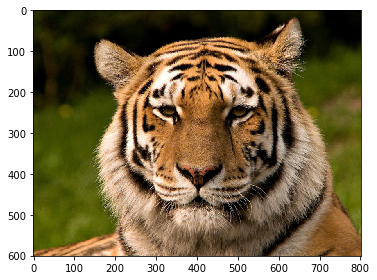

In [19]:
imshow(img)
# Исходное изображение

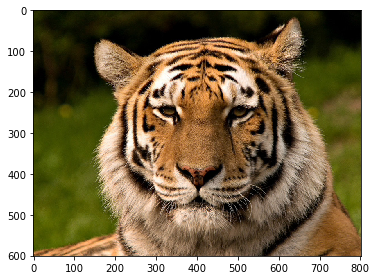

In [20]:
imshow(rgb_img)
#  После декодирования

In [21]:
def count_entropy_one_channel(img) -> float:
    img = img_as_ubyte(img)
    size = img.shape[0] * img.shape[1]
    entropy = 0
    h, bins = histogram(img, bins=range(256))
    values = list(h)
    #  Кол-во информации на один пиксель
    for v in values:
        if v:
            entropy += (v / size) * log((v/size), 2)
    #  Энтропия картинки
    entropy *= (-1 * size)
    return entropy


'''
def count_rgb_entropy(img) -> float:
    img = img_as_ubyte(img)
    size = img.shape[0] * img.shape[1]
    entropy = 0
    count = {}
    for x in range(img.shape[0]):
        for y in range(img.shape[1]):
            colour = str(img[x, y])
            if colour in count.keys():
                count[colour] += 1
            else:
                count[colour] = 1
    #  Кол-во информации на один пиксель
    for colour in count.keys():
            entropy += (count[colour] / size) * log((count[colour]/size), 2)
    #  Энтропия картинки
    entropy *= -1 * size
    return entropy
'''


def count_rgb_entropy(img) -> float:
    '''Кол-во информации по каждому каналу отдельно '''
    img = img_as_ubyte(img)
    size = img.shape[0] * img.shape[1]
    entropy = 0
    for ch in range(3):
        ch_entropy = 0
        h, bins = histogram(img[:, :, ch], bins=range(256))
        values = list(h)
        #  Кол-во информации на один пиксель
        for v in values:
            if v:
                ch_entropy += (v / size) * log((v/size), 2)
        print(f'Вес одного пикселя RGB {ch}: {ch_entropy}')
        #  Энтропия канала
        ch_entropy *= (-1 * size)
        #  Энтропия картинки
        entropy += ch_entropy
    return entropy


def count_yuv_entropy(yuv) -> float:
    entropy = 0
    for ch in range(3):
        ch_entropy = 0
        count = {}
        size = yuv[ch].shape[0] * yuv[ch].shape[1]
        for x in range(yuv[ch].shape[0]):
            for y in range(yuv[ch].shape[1]):
                colour = str(yuv[ch][x, y])
                if colour in count.keys():
                    count[colour] += 1
                else:
                    count[colour] = 1
        print(len(count.keys()))
        #  Кол-во информации на один пиксель
        for colour in count.keys():
            entropy += (count[colour] / size) * log((count[colour]/size), 2)
        #  Энтропия канала
        print(f'Вес одного пикселя YUV {ch}: {ch_entropy}')
        entropy *= (-1 * size)
        #  Энтропия картинки
        entropy += ch_entropy
    return entropy


def count_standard_deviation(img1, img2) -> float:
    '''params:
    img1 - original image
    img2 - image after decoding '''
    img1 = img_as_ubyte(img1)
    img2 = img_as_ubyte(img2)
    deviation_sum = 0
    try:
        for x in range(img1.shape[0]):
            for y in range(img1.shape[1]):
                deviation_sum += ((img1[x, y][0] - img2[x, y][0]) ** 2 +
                                  (img1[x, y][1] - img2[x, y][1]) ** 2 +
                                  (img1[x, y][2] - img2[x, y][2]) ** 2)
        standard_deviation = deviation_sum / (img1.shape[0] * img1.shape[1] * 3)
    except IndexError:
        for x in range(img1.shape[0]):
            for y in range(img1.shape[1]):
                deviation_sum += (img1[x, y] - img2[x, y]) ** 2
        standard_deviation = deviation_sum / (img1.shape[0] * img1.shape[1])
    return standard_deviation

In [22]:
img3 = imread('C:\cs173\\lab1\\img.png')
img = img3
count = {}
for x in range(img.shape[0]):
    for y in range(img.shape[1]):
        colour = str(img[x, y][0])
        if colour in count.keys():
            count[colour] += 1
        else:
            count[colour] = 1
print(len(count.keys()))

yuv = rgb_to_yuv(img3)
img = yuv[0]
count = {}
for x in range(img.shape[0]):
    for y in range(img.shape[1]):
        colour = str(img[x, y])
        if colour in count.keys():
            count[colour] += 1
        else:
            count[colour] = 1
print(len(count.keys()))
# print(count_yuv_entropy(yuv_img))

256
168271


In [23]:
img1 = imread('C:\cs173\lab1\eye.jpg')
img1 = rgb2gray(img1)
img1 = img_as_ubyte(img1)
img2 = imread('C:\cs173\lab1\\restored_img_16_levels.png')
downgraded_img = downgrade(img1, 16)
print('Уменьшение уровней яркости:')
print('Энтропия до:', count_entropy_one_channel(img1))
print('Энтропия после:', count_entropy_one_channel(downgraded_img))
print('Среднеквадратичная ошибка:')
print(count_standard_deviation(img1, img2), '\n')

img3 = imread('C:\cs173\\lab1\\img.png')
img4 = imread('C:\cs173\\lab1\\rgb_img.png')
yuv_img = rgb_to_yuv(img3)
print('Из RGB в YUV:')
print('Энтропия до:', count_rgb_entropy(img3))
print('Энтропия после:', count_yuv_entropy(yuv_img))
print('Среднеквадратичная ошибка:')
print(count_standard_deviation(img3, img4))

Уменьшение уровней яркости:
Энтропия до: 580063.888737709
Энтропия после: 291394.6869740097
Среднеквадратичная ошибка:
76.74442789438051 

Из RGB в YUV:
Вес одного пикселя RGB 0: -7.863871774423019
Вес одного пикселя RGB 1: -7.627986947364539
Вес одного пикселя RGB 2: -6.688709729507241
Энтропия до: 10677747.833021767
168271
Вес одного пикселя YUV 0: 0
19616
Вес одного пикселя YUV 1: 0
28792
Вес одного пикселя YUV 2: 0
Энтропия после: 1.1074111010703656e+17
Среднеквадратичная ошибка:
893.4028651096834
